<h1><center>COVID-19. Детекция Атипичной пневмонии по рентгеновским снимкам</center></h1>

<center><img src = "https://ichef.bbci.co.uk/news/800/cpsprodpb/1EA6/production/_110764870_coronavirusmedium.jpg.webp" width = "750" height = "500"/></center>

<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:blue; border:0; color:white' role="tab" aria-controls="home"><center>[Тренировка Модели]</center></h2>

### Ссылки

[Detectron_offical](https://github.com/facebookresearch/detectron2)

[VinBigData detectron2](https://www.kaggle.com/corochann/vinbigdata-detectron2-train)

[Detectron2 Tutorial](https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5#scrollTo=QHnVupBBn9eR)

[Albumentastions in detectron2](https://www.kaggle.com/dhiiyaur/detectron-2-compare-models-augmentation/#data)

В качестве фреймворка я выбрал Detectron2 по ряду причин:

    - Субъективно нравится
    - Понятный мануал
    - Неплохие результаты ( пробовал его в соревновании на Кагле)
    - Возможность гибкой настройки обучения

**DETECTRON2**

Detectron2 - это система нового поколения от Facebook AI Research, реализующая самые современные алгоритмы обнаружения объектов.

# Импорт Библиотек

In [1]:
import numpy as np 
import pandas as pd 
from datetime import datetime
import time
import matplotlib.pyplot as plt

import os, json, cv2, random
import skimage.io as io
import copy
import logging
import pickle
from pathlib import Path
from typing import Optional

import torch

# Albumenatations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import warnings

#import config
from config import Flags
from COVID19_dict import build_COVID19_data_dicts

In [2]:
# detectron2
from detectron2.structures import BoxMode
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.engine import DefaultPredictor, DefaultTrainer, launch
from detectron2.evaluation import COCOEvaluator
from detectron2.structures import BoxMode
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer

from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader, build_detection_train_loader
from detectron2.data import detection_utils as utils


from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader, build_detection_train_loader
from detectron2.data import detection_utils as utils
import detectron2.data.transforms as T
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.evaluation.evaluator import DatasetEvaluator
from detectron2.config.config import CfgNode as CN

setup_logger()

<Logger detectron2 (DEBUG)>

In [3]:
warnings.filterwarnings('ignore')

%matplotlib inline
plt.style.use('ggplot')

## Configs

In [4]:
# Словарь конфигураций
# Его мы загрузим а класс Flags
flags_dict = {
    "debug": False,
    "outdir": "./output/", 
    "imgdir_name": './dataset/resized_pics',  #"imgdir_name": './dataset/SIIM-COVID19-Resized/img_sz_640', !!!!!!!!!!!!!!!!!!
    "split_mode": "valid20",
    "iter": 5000,
    "roi_batch_size_per_image": 128,
    "eval_period": 1000,
    "lr_scheduler_name": "WarmupCosineLR",
    "base_lr": 0.02,
    "num_workers": 4,
    "aug_kwargs": {
        #"Resize": {640},
        "HorizontalFlip": {"p": 0.5},
        "ShiftScaleRotate": {"scale_limit": 0.15, "rotate_limit": 10, "p": 0.5},
        "RandomBrightnessContrast": {"p": 0.5},
        "GaussNoise": {"p": 0.2},
        "HueSaturationValue": {"p":0.2}
    }
}

In [5]:
# Конфигупационный класс
flags = Flags().update(flags_dict)
print(flags)

Flags(debug=False, outdir='./output/', imgdir_name='./dataset/resized_pics', split_mode='valid20', iter=5000, warm_up_iters=1000, ims_per_batch=2, num_workers=4, lr_scheduler_name='WarmupCosineLR', base_lr=0.02, roi_batch_size_per_image=128, eval_period=1000, aug_kwargs={'HorizontalFlip': {'p': 0.5}, 'ShiftScaleRotate': {'scale_limit': 0.15, 'rotate_limit': 10, 'p': 0.5}, 'RandomBrightnessContrast': {'p': 0.5}, 'GaussNoise': {'p': 0.2}, 'HueSaturationValue': {'p': 0.2}})


In [6]:
classes = [
    "atypical",
    "indeterminate",
    "negative",
    "typical"
]

debug=flags.debug
outdir = Path(flags.outdir)
split_mode=flags.split_mode # Or  "all_train"

category_name_to_id = {
    class_name: index for index, class_name in enumerate(classes)
}

print(category_name_to_id)

{'atypical': 0, 'indeterminate': 1, 'negative': 2, 'typical': 3}


# Загрузка данных

In [7]:
imdir = flags.imgdir_name
# imdir = f'{config.DATA_ROOT_RESIZED}/img_sz_640'
# # Загрузим CSV полученный в ноутбуке с EDA
train_df = pd.read_csv(f'{flags.root}/train_image_df.csv')
print(f'Number of studies: {len(train_df)}')

Number of studies: 5822


<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:orange; border:0; color:white' role="tab" aria-controls="home"><center>[Подготовка данных]</center></h2>

Для определения кстомного датасета, нам нужно создать **список словарей** (dataset_dicts) где каждый словарь содержит:

 - file_name: имя файла изображения
 - image_id: id изображения, (он же индекс).
 - height: высота изображения.
 - width: Ширина изображения.
 - annotation: основные аннотационные данные для обнаружения объектов, которые содержат следующее:
   - bbox: bounding box pixel location имеющий shape n_boxes,4
   - bbox_mode: Тут тспользуется BoxMode.XYXY_ABS. Абсолютное значение (x_min, y_min, x_max, y_max) аннотаций используется в bbox
   - category_id: class label id for each bounding box, with shape (n_boxes,)


*build_COVID19_data_dicts* для подготовки тренировочных даных
*build_COVID19_data_dicts* c аргументом *test* для подготовки тестовых даных

Этот *dataset_dicts* содержит метаданные для фактических данных, передаваемых в нейронную сеть.
Он загружается перед обучением в памяти, поэтому он должен содержать все метаданные (путь к файлу изображения и т. д.) для создания набора обучающих данных, но не должен содержать **тяжелые данные**. 

На практике загрузка всех связанных массивов изображений слишком велика для загрузки в память, поэтому они загружаются внутри DataLoader по требованию (Это делается при помощи класса *mapper в detectron2*

In [8]:
if split_mode == "all_train":
    print("selected split mode is ALL_TRAIN")
    DatasetCatalog.register(
        "COVID19_data_train",
        lambda: build_COVID19_data_dicts(
            imdir,
            train_df,
            debug=debug,
            data_type="train",
            cache_mode='All'
        ),
    )
    MetadataCatalog.get("COVID19_data_train").set(thing_classes=classes)
    
    
    dataset_dicts_train = DatasetCatalog.get("COVID19_data_train")
    metadata_dicts_train = MetadataCatalog.get("COVID19_data_train")
    
elif split_mode == 'valid20':
    print("selected split mode is valid20'")
    n_dataset = len(
        build_COVID19_data_dicts(
            imdir,
            train_df,
            debug=debug,
            data_type = 'train',
            cache_mode='All'
        )
    )
    n_train = int(n_dataset * 0.90)
    print(f'All_dataset_size: {n_dataset}, train_dataset_size: {n_train}')
    rs = np.random.RandomState(42)
    inds = rs.permutation(n_dataset)
    train_inds, valid_inds = inds[:n_train], inds[n_train:]
    # Регестрируем тренировочный датасет
    DatasetCatalog.register(
        "COVID19_data_train",
        lambda: build_COVID19_data_dicts(
            imdir,
            train_df,
            target_indices=train_inds,
            debug=debug,
            data_type="train",
            cache_mode='train'
        ),
    )
    MetadataCatalog.get("COVID19_data_train").set(thing_classes=classes)
    # Регестрируем валидационный датасет
    DatasetCatalog.register(
        "COVID19_data_valid",
        lambda: build_COVID19_data_dicts(
            imdir,
            train_df,
            target_indices=train_inds,
            debug=debug,
            data_type="train",
            cache_mode='val'
        ),
    )
    MetadataCatalog.get("COVID19_data_valid").set(thing_classes=classes)
    
    dataset_dicts_train = DatasetCatalog.get("COVID19_data_train")
    metadata_dicts_train = MetadataCatalog.get("COVID19_data_train")
    
    dataset_dicts_valid = DatasetCatalog.get("COVID19_data_valid")
    metadata_dicts_valid = MetadataCatalog.get("COVID19_data_valid")
    
else:
    raise ValueError(f"[ERROR] Unexpected value split_mode={split_mode}")

selected split mode is valid20'
Load from cache dataset_dicts_cache_All.pkl
All_dataset_size: 6334, train_dataset_size: 5700
Load from cache dataset_dicts_cache_train.pkl
Load from cache dataset_dicts_cache_val.pkl


# Визуализация данных

Проверим, что подготовленный датасет работает коррекно. Печатнем пару картинок

Detectron2 в своем арсенале имеет инструменты по визуализации. Это упрощает нам жизнь. Для получения таких же изображений в ноутбуке  Анализа данных была написана не одна громоздкая функция и не одна клавиатура была сломана 😂. 

В детектроне же есть класс Visualizer

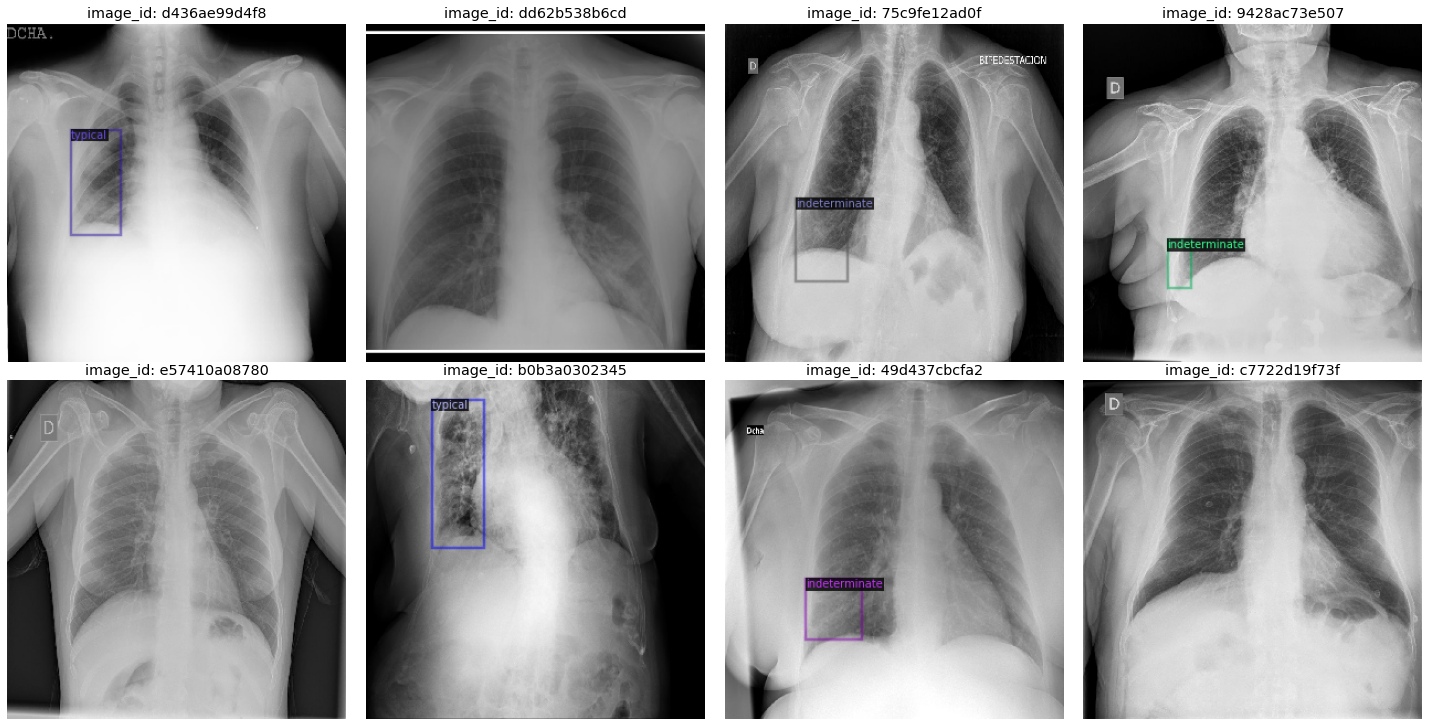

In [9]:
fig, ax = plt.subplots(2, 4, figsize =(20,10))
indices=[ax[0][0],ax[1][0],ax[0][1],ax[1][1],ax[0][2],ax[1][2],ax[0][3],ax[1][3]]
i=-1
for d in random.sample(dataset_dicts_train, 8):
    i+=1    
    img = cv2.imread(d["file_name"])
    v = Visualizer(img[:, :, ::-1],
                   metadata=metadata_dicts_train, 
                   scale=0.3, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_dataset_dict(d)
    indices[i].grid(False)
    indices[i].axis('off')
    indices[i].set_title(f'image_id: {d["image_id"]}')
    indices[i].imshow(out.get_image()[:, :, ::-1])
plt.tight_layout(pad=0.5)

# DATALOADER

Detectron2 содержит в себе 2 встроенных пайплайна загрузки данных. build_detection_{train,test}_loader
 - [ref : detectron2 docs "Dataloader"](https://detectron2.readthedocs.io/en/latest/tutorials/data_loading.html)


Класс Mapper используется внутри DataLoader. Он отвечает за преобразование dataset_dicts в фактические данные, передаваемые в нейронную сеть, и мы можем вставить аугментации в этот класс Mapper.

Другими словами - грузим из зарегестрированного датасета спсиок словарей, обрабатываем мапером, который может включать в себя аугментации и подаем с сетку

Напишем два кастомных мапера. Один использует аугментации, реализованные в Detectron2, а второй AlbumentationsMapper, который использует аугментации библиотеки Albumentations.

##  Мапер со встроенными трансформациями

In [10]:
"""
Referenced:
 - https://detectron2.readthedocs.io/en/latest/tutorials/data_loading.html
 - https://www.kaggle.com/dhiiyaur/detectron-2-compare-models-augmentation/#data
"""

class MyMapper:
    '''
    Mapper which uses 'detectron2.data.transform' augmentations
    '''

    def __init__(self, cfg, is_train: bool = True):
        '''
        :param cfg: detectron2 configuration
        :param is_train: True if train
        '''
        #aug_kwargs = cfg.aug_kwargs
        aug_list = [
            T.Resize((1024, 1024)), #(640, 640)
            T.RandomBrightness(0.8, 1.2),
            T.RandomFlip(prob=0.5, horizontal=False, vertical=True),
            T.RandomFlip(prob=0.5, horizontal=True, vertical=False)
        ]
        # if is_train:
        #     aug_list.extend([getattr(T, name)(**kwargs) for name, kwargs in aug_kwargs.items()])
        self.augmentations = T.AugmentationList(aug_list)
        self.is_train = is_train
        mode = "training" if is_train else "inference"
        print(f"[MyDatasetMapper] Augmentations used in {mode}: {self.augmentations}")

    def __call__(self, dataset_dict):
        dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
        image = utils.read_image(dataset_dict["file_name"], format="BGR")

        aug_input = T.AugInput(image)
        transforms = self.augmentations(aug_input)
        image = aug_input.image

        image_shape = image.shape[:2]  # h, w
        dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))
        annos = [
            utils.transform_instance_annotations(obj, transforms, image_shape)
            for obj in dataset_dict.pop("annotations")
            if obj.get("iscrowd", 0) == 0
        ]
        instances = utils.annotations_to_instances(annos, image_shape)
        dataset_dict["instances"] = utils.filter_empty_instances(instances)
        return dataset_dict

##  Мапер с трансформациями Albumentations

In [11]:
# class AlbumentationsMapper:
#     """Mapper which uses `albumentations` augmentations"""
#     def __init__(self, cfg, is_train: bool = True):
#         aug_kwargs = cfg.aug_kwargs
#         aug_list = []
#         if is_train:0.02
#             aug_list.extend([getattr(A, name)(**kwargs) for name, kwargs in aug_kwargs.items()])
#         self.transform = A.Compose(
#             aug_list, bbox_params=A.BboxParams(format="pascal_voc", label_fields=["category_ids"])
#         )
#         self.is_train = is_train

#         mode = "training" if is_train else "inference"
#         print(f"[AlbumentationsMapper] Augmentations used in {mode}: {self.transform}")

#     def __call__(self, dataset_dict):
#         dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
#         image = utils.read_image(dataset_dict["file_name"], format="BGR")

#         # aug_input = T.AugInput(image)
#         # transforms = self.augmentations(aug_input)
#         # image = aug_input.image

#         prev_anno = dataset_dict["annotations"]
#         bboxes = np.array([obj["bbox"] for obj in prev_anno], dtype=np.float32)
#         # category_id = np.array([obj["category_id"] for obj in dataset_dict["annotations"]], dtype=np.int64)
#         category_id = np.arange(len(dataset_dict["annotations"]))

#         transformed = self.transform(image=image, bboxes=bboxes, category_ids=category_id)
#         image = transformed["image"]
#         annos = []
#         for i, j in enumerate(transformed["category_ids"]):
#             d = prev_anno[j]
#             d["bbox"] = transformed["bboxes"][i]
#             annos.append(d)
#         dataset_dict.pop("annotations", None)  # Remove unnecessary field.

#         # if not self.is_train:
#         #     # USER: Modify this if you want to keep them for some reason.
#         #     dataset_dict.pop("annotations", None)
#         #     dataset_dict.pop("sem_seg_file_name", None)
#         #     return dataset_dict

#         image_shape = image.shape[:2]  # h, w
#         dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))
#         instances = utils.annotations_to_instances(annos, image_shape)
#         dataset_dict["instances"] = utils.filter_empty_instances(instances)
#         return dataset_dict

## Evaluator

In [13]:
# Taken from https://www.kaggle.com/theoviel/competition-metric-map-iou
def precision_at(threshold, iou):
    matches = iou > threshold
    true_positives = np.sum(matches, axis=1) == 1  # Correct objects
    false_positives = np.sum(matches, axis=0) == 0  # Missed objects
    false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
    return np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)

def score(pred, targ):
    pred_masks = pred['instances'].pred_masks.cpu().numpy()
    enc_preds = [mask_util.encode(np.asarray(p, order='F')) for p in pred_masks]
    enc_targs = list(map(lambda x:x['segmentation'], targ))
    ious = mask_util.iou(enc_preds, enc_targs, [0]*len(enc_targs))
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, ious)
        p = tp / (tp + fp + fn)
        prec.append(p)
    return np.mean(prec)

In [13]:
class MAPIOUEvaluator(DatasetEvaluator):
    def __init__(self, dataset_name):
        dataset_dicts = DatasetCatalog.get(dataset_name)
        self.annotations_cache = {item['image_id']:item['annotations'] for item in dataset_dicts}
            
    def reset(self):
        self.scores = []

    def process(self, inputs, outputs):
        for inp, out in zip(inputs, outputs):
            if len(out['instances']) == 0:
                self.scores.append(0)    
            else:
                targ = self.annotations_cache[inp['image_id']]
                self.scores.append(score(out, targ))

    def evaluate(self):
        return {"MaP IoU": np.mean(self.scores)}

## MyTrainer

MyTrainer переопределяет метод build_evaluator класса DefaultTrainer, предоставляемый detectron2, для поддержки оценки набора данных проверки. 

 - build_train_loader и build_test_loader: эти методы класса определяют, как построить DataLoader для данных обучения и данных проверки соответственно. Здесь AlbumentationMapper передается для создания DataLoader для вставки настраиваемого процесса аугментаций. 

In [14]:
# class MyTrainer(DefaultTrainer):
#     @classmethod
#     def build_train_loader(cls, cfg, sampler=None):
#         return build_detection_train_loader(
#             cfg, mapper=AlbumentationsMapper(cfg, True), sampler=sampler
#         )
#     # @classmethod
#     # def build_test_loader(cls, cfg, dataset_name):
#     #     return build_detection_test_loader(
#     #         cfg, dataset_name, mapper=AlbumentationsMapper(cfg, False)
#     #     )
#     @classmethod
#     def build_evaluator(cls, cfg, dataset_name):
#         return MAPIOUEvaluator(dataset_name)

In [12]:
class MyTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg, sampler=None):
        return build_detection_train_loader(
            cfg, mapper=MyMapper(cfg, True), sampler=sampler
        )

## Загрузка параметров в модель

In [13]:
cfg = get_cfg()
cfg.aug_kwargs = CN(flags.aug_kwargs)  # pass aug_kwargs to cfg
config_name = "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"
cfg.merge_from_file(model_zoo.get_config_file(config_name))
cfg.DATASETS.TRAIN = ("COVID19_data_train",)

if split_mode == "all_train":
    cfg.DATASETS.TEST = ()
else:
    cfg.DATASETS.TEST = ("COVID19_data_valid",)
    cfg.TEST.EVAL_PERIOD = 1000#flags.eval_period

cfg.DATALOADER.NUM_WORKERS = 0#flags.num_workers
cfg.MODEL.WEIGHTS=model_zoo.get_checkpoint_url(config_name)
#cfg.MODEL.WEIGHTS="/home/paul/Github/MFTI_CV/Final Project/output/model_final.pth"

#cfg.SOLVER.LR_SCHEDULER_NAME = flags.lr_scheduler_name
cfg.SOLVER.IMS_PER_BATCH = 2#flags.ims_per_batch
cfg.SOLVER.BASE_LR = 0.002#flags.base_lr

cfg.SOLVER.WARMUP_ITERS = 1000#flags.warm_up_iters
cfg.SOLVER.MAX_ITER = 5000#flags.iter #adjust up if val mAP is still rising, adjust down if overfit

cfg.SOLVER.CHECKPOINT_PERIOD = 100000  # Small value=Frequent save need a lot of storage.
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128#flags.roi_batch_size_per_image
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4

#cfg.SOLVER.STEPS = (100, 500) # must be less than  MAX_ITER 
#cfg.SOLVER.GAMMA = 0.05

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

## Визуализация Аугментаций

Проверим, что аугментации работают корректно.

Так как мапер используется внутри DataLoader, проверим его поведение и напечатаем пару изображений

Ниже приведен код для визуализации одних и тех же данных 4 раза. Мы можем проверить, применяется ли аугментация, и каждый раз изображение выглядит по-разному. 

Также стоит заметить, что bbox обрабатывается корректно. Если изображение масштабируется или поворачивается, то и рамка поворачивается вместе с изображением

In [16]:
covid_meta = MetadataCatalog.get("COVID19_data_train").set(thing_classes=classes)

[MyDatasetMapper] Augmentations used in training: AugmentationList[Resize(shape=(1024, 1024)), RandomBrightness(intensity_min=0.8, intensity_max=1.2), RandomFlip(prob=0.5, horizontal=False, vertical=True), RandomFlip(prob=0.5)]
Load from cache dataset_dicts_cache_train.pkl
[01/12 22:24:41 d2.data.build]: Removed 1928 images with no usable annotations. 3772 images left.
[01/12 22:24:41 d2.data.common]: Serializing 3772 elements to byte tensors and concatenating them all ...
[01/12 22:24:41 d2.data.common]: Serialized dataset takes 1.10 MiB
Visualization img (1024, 1024, 3) saved in output/vinbigdata_0_aug0.jpg
Visualization img (1024, 1024, 3) saved in output/vinbigdata_1_aug0.jpg
[MyDatasetMapper] Augmentations used in training: AugmentationList[Resize(shape=(1024, 1024)), RandomBrightness(intensity_min=0.8, intensity_max=1.2), RandomFlip(prob=0.5, horizontal=False, vertical=True), RandomFlip(prob=0.5)]
Load from cache dataset_dicts_cache_train.pkl
[01/12 22:24:41 d2.data.build]: Remov

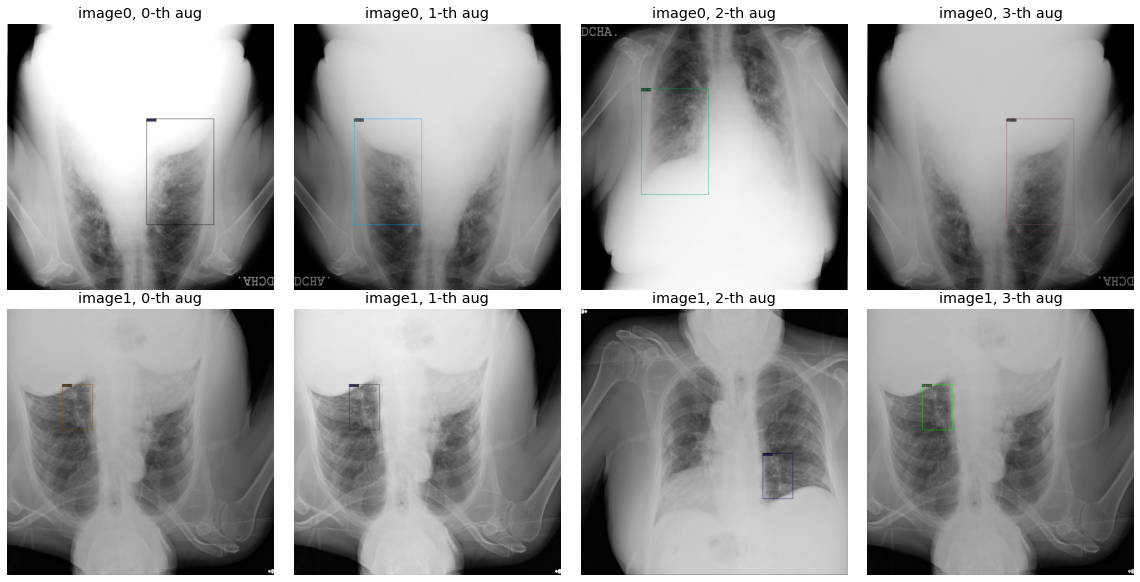

In [18]:
# Visualize data...
# import matplotlib.pyplot as plt
from detectron2.data.samplers import TrainingSampler

n_images = 2
n_aug = 4

fig, axes = plt.subplots(n_images, n_aug, figsize=(16, 8))

# Ref https://github.com/facebookresearch/detectron2/blob/22b70a8078eb09da38d0fefa130d0f537562bebc/tools/visualize_data.py#L79-L88
for i in range(n_aug):
    sampler = TrainingSampler(len(dataset_dicts_train), shuffle=False)
    train_vis_loader = MyTrainer.build_train_loader(
        cfg, sampler=sampler
    )  # For visualization...
    for batch in train_vis_loader:
        for j, per_image in enumerate(batch):
            ax = axes[j, i]

            img_arr = per_image["image"].cpu().numpy().transpose((1, 2, 0))
            visualizer = Visualizer(
                img_arr[:, :, ::-1], metadata=covid_meta, scale=1.0
            )
            target_fields = per_image["instances"].get_fields()
            labels = [
                covid_meta.thing_classes[i] for i in target_fields["gt_classes"]
            ]
            out = visualizer.overlay_instances(
                labels=labels,
                boxes=target_fields.get("gt_boxes", None),
                masks=target_fields.get("gt_masks", None),
                keypoints=target_fields.get("gt_keypoints", None),
            )
            # out = visualizer.draw_dataset_dict(per_image)

            img = out.get_image()[:, :, ::-1]
            filepath = str(outdir / f"vinbigdata_{j}_aug{i}.jpg")
            cv2.imwrite(filepath, img)
            print(f"Visualization img {img_arr.shape} saved in {filepath}")
            ax.imshow(img)
            ax.set_title(f"image{j}, {i}-th aug")
            ax.set_axis_off()
            
        break
fig.tight_layout(pad=0.5)

In [14]:
#Training using custom trainer defined above
trainer = MyTrainer(cfg)
#trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[01/12 22:38:26 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (5, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (5,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (16, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (16,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, 

[01/12 22:38:26 d2.engine.train_loop]: Starting training from iteration 0
[01/12 22:38:33 d2.utils.events]:  eta: 0:28:21  iter: 19  total_loss: 1.813  loss_cls: 1.548  loss_box_reg: 0.2888  loss_rpn_cls: 0.02047  loss_rpn_loc: 0.01127  time: 0.3441  data_time: 0.0465  lr: 3.9962e-05  max_mem: 2668M
[01/12 22:38:40 d2.utils.events]:  eta: 0:28:30  iter: 39  total_loss: 1.004  loss_cls: 0.6243  loss_box_reg: 0.2342  loss_rpn_cls: 0.03351  loss_rpn_loc: 0.01252  time: 0.3502  data_time: 0.0503  lr: 7.9922e-05  max_mem: 2668M
[01/12 22:38:47 d2.utils.events]:  eta: 0:28:17  iter: 59  total_loss: 0.5857  loss_cls: 0.336  loss_box_reg: 0.218  loss_rpn_cls: 0.02196  loss_rpn_loc: 0.01302  time: 0.3492  data_time: 0.0475  lr: 0.00011988  max_mem: 2668M
[01/12 22:38:54 d2.utils.events]:  eta: 0:28:07  iter: 79  total_loss: 0.777  loss_cls: 0.3834  loss_box_reg: 0.3698  loss_rpn_cls: 0.01726  loss_rpn_loc: 0.009603  time: 0.3475  data_time: 0.0446  lr: 0.00015984  max_mem: 2668M
[01/12 22:39:01

KeyboardInterrupt: 